# Hito 2
*sólo variables de hipótesis*



In [1]:
import pandas as pd
import seaborn as sns

from scipy import stats
import numpy as np

from google.colab import auth
from google.cloud import bigquery

In [2]:
auth.authenticate_user()

project_id = 'saltoproyecto3'
client = bigquery.Client(project=project_id)

query = """
SELECT *
FROM `saltoproyecto3.riesgorelativo.combined_view_1`
"""

query_job = client.query(query)

df = query_job.to_dataframe()

df.head()

,user_id,number_dependents,age,last_month_salary,category,generation,default_flag,more_90_days_overdue,using_lines_not_secured_personal_assets,number_times_delayed_payment_loan_30_59_days,debt_ratio,number_times_delayed_payment_loan_60_89_days,loan_count,real_estate,others,loan_group,m9do_group,dr_group,ulnspa_group
0,19807,0,23,2500,bad_payer,q1,1,1,1.155528,1,687.000000,1,3,0,3,q1,q2,q4,q4
1,29366,0,24,620,bad_payer,q1,1,1,1.245902,1,0.935588,1,3,0,3,q1,q2,q3,q4
2,35241,0,24,2500,bad_payer,q1,1,1,1.000000,1,286.000000,0,1,0,1,q1,q2,q4,q4
3,1460,0,25,3800,bad_payer,q1,1,1,1.057648,1,0.102605,1,4,0,4,q1,q2,q1,q4
4,2554,0,25,974,bad_payer,q1,1,1,2.638723,1,0.521026,1,4,0,4,q1,q2,q3,q4


In [3]:
df_dummies = pd.get_dummies(df, columns=['generation', 'loan_group', 'm9do_group'], drop_first=False)
df_dummies.drop(columns=['generation_q1', 'loan_group_q1', 'm9do_group_q3'], inplace=True)
print(df_dummies)

       user_id  number_dependents  age  last_month_salary    category  \
0        19807                  0   23               2500   bad_payer   
1        29366                  0   24                620   bad_payer   
2        35241                  0   24               2500   bad_payer   
3         1460                  0   25               3800   bad_payer   
4         2554                  0   25                974   bad_payer   
...        ...                ...  ...                ...         ...   
32581    31651                  8   63                905  good_payer   
32582    12123                  9   37               3300  good_payer   
32583    34884                  9   48              11400  good_payer   
32584    14692                 10   47               9166  good_payer   
32585    15517                 13   53               3333  good_payer   

       default_flag  more_90_days_overdue  \
0                 1                     1   
1                 1              

In [7]:
# Definir los pesos para cada dummy (excluyendo las categorías de referencia)
# de prueba, los pesos no tienen relación con algún análisis hecho previamente
weights = {
    'generation_q2': 0.4,
    'generation_q3': 0.3,
    'generation_q4': 0.2,
    'loan_group_q2': 0.4,
    'loan_group_q3': 0.3,
    'loan_group_q4': 0.2,
    'm9do_group_q1': 0.2,
    'm9do_group_q2': 0.4,
    'm9do_group_q4': 0.3
}

# Calcular el score
df_dummies['score'] = (
    df_dummies['generation_q2'] * weights['generation_q2'] +
    df_dummies['generation_q3'] * weights['generation_q3'] +
    df_dummies['generation_q4'] * weights['generation_q4'] +
    df_dummies['loan_group_q2'] * weights['loan_group_q2'] +
    df_dummies['loan_group_q3'] * weights['loan_group_q3'] +
    df_dummies['loan_group_q4'] * weights['loan_group_q4'] +
    df_dummies['m9do_group_q1'] * weights['m9do_group_q1'] +
    df_dummies['m9do_group_q2'] * weights['m9do_group_q2'] +
    df_dummies['m9do_group_q4'] * weights['m9do_group_q4']
)

print(df_dummies[['score'] + list(weights.keys())])


       score  generation_q2  generation_q3  generation_q4  loan_group_q2  \
0        0.4          False          False          False          False   
1        0.4          False          False          False          False   
2        0.4          False          False          False          False   
3        0.4          False          False          False          False   
4        0.4          False          False          False          False   
...      ...            ...            ...            ...            ...   
32581    0.4          False          False           True          False   
32582    0.8          False          False          False           True   
32583    0.9           True          False          False          False   
32584    1.0           True          False          False           True   
32585    0.7          False           True          False          False   

       loan_group_q3  loan_group_q4  m9do_group_q1  m9do_group_q2  \
0              Fal

In [8]:
# Uso de prueba de la mediana como umbral de score
threshold = df_dummies['score'].median()


df_dummies['predicted_default'] = np.where(df_dummies['score'] > threshold, 1, 0)


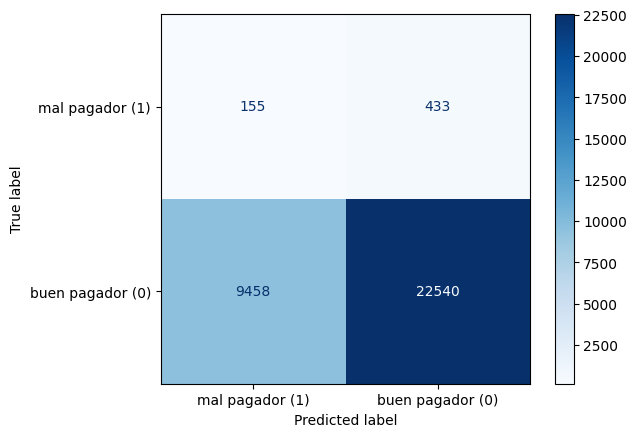

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


df_dummies['true_default'] = df['default_flag']

# matriz de confusión
cm = confusion_matrix(df_dummies['true_default'], df_dummies['predicted_default'], labels=[1, 0])

# Mostrar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['mal pagador (1)', 'buen pagador (0)'])
disp.plot(cmap="Blues")


In [10]:
# Matriz de prueba
from sklearn.metrics import classification_report

print(classification_report(df_dummies['true_default'], df_dummies['predicted_default'], target_names=['buen pagador (0)', 'mal pagador (1)']))


                  precision    recall  f1-score   support

buen pagador (0)       0.98      0.70      0.82     31998
 mal pagador (1)       0.02      0.26      0.03       588

        accuracy                           0.70     32586
       macro avg       0.50      0.48      0.43     32586
    weighted avg       0.96      0.70      0.81     32586



# Hito 2
*5 variables consideradas para el score*


In [13]:
# Nueva definición de dummies con niveles de referencia conocidos (grupos de variables con alto riesgo relativo calculado)
df_dummies = pd.get_dummies(df, columns=['generation', 'loan_group', 'm9do_group', 'dr_group', 'ulnspa_group'], drop_first=False)
df_dummies.drop(columns=['generation_q1', 'loan_group_q1', 'm9do_group_q3', 'dr_group_q3', 'ulnspa_group_q4'], inplace=True)
print(df_dummies)

       user_id  number_dependents  age  last_month_salary    category  \
0        19807                  0   23               2500   bad_payer   
1        29366                  0   24                620   bad_payer   
2        35241                  0   24               2500   bad_payer   
3         1460                  0   25               3800   bad_payer   
4         2554                  0   25                974   bad_payer   
...        ...                ...  ...                ...         ...   
32581    31651                  8   63                905  good_payer   
32582    12123                  9   37               3300  good_payer   
32583    34884                  9   48              11400  good_payer   
32584    14692                 10   47               9166  good_payer   
32585    15517                 13   53               3333  good_payer   

       default_flag  more_90_days_overdue  \
0                 1                     1   
1                 1              

In [14]:
# Pesos definidos en función de su nivel de riesgo relativo calculado
weights = {
    'generation_q2': 0.5,
    'generation_q3': 0,
    'generation_q4': 0,
    'loan_group_q2': 0.2,
    'loan_group_q3': 0,
    'loan_group_q4': 0,
    'm9do_group_q1': 0,
    'm9do_group_q2': 2,
    'm9do_group_q4': 1,
    'dr_group_q1': 0,
    'dr_group_q2': 0,
    'dr_group_q4':0.2,
    'ulnspa_group_q1': 0,
    'ulnspa_group_q2': 0,
    'ulnspa_group_q3':0
}

# Score
df_dummies['score'] = (
    df_dummies['generation_q2'] * weights['generation_q2'] +
    df_dummies['generation_q3'] * weights['generation_q3'] +
    df_dummies['generation_q4'] * weights['generation_q4'] +
    df_dummies['loan_group_q2'] * weights['loan_group_q2'] +
    df_dummies['loan_group_q3'] * weights['loan_group_q3'] +
    df_dummies['loan_group_q4'] * weights['loan_group_q4'] +
    df_dummies['m9do_group_q1'] * weights['m9do_group_q1'] +
    df_dummies['m9do_group_q2'] * weights['m9do_group_q2'] +
    df_dummies['m9do_group_q4'] * weights['m9do_group_q4']+
    df_dummies['dr_group_q1'] * weights['dr_group_q1']+
    df_dummies['dr_group_q2'] * weights['dr_group_q2']+
    df_dummies['dr_group_q4'] * weights['dr_group_q4']+
    df_dummies['ulnspa_group_q1'] * weights['ulnspa_group_q1']+
    df_dummies['ulnspa_group_q2'] * weights['ulnspa_group_q2']+
    df_dummies['ulnspa_group_q3'] * weights['ulnspa_group_q3']
)

print(df_dummies[['score'] + list(weights.keys())])


       score  generation_q2  generation_q3  generation_q4  loan_group_q2  \
0        2.2          False          False          False          False   
1        2.0          False          False          False          False   
2        2.2          False          False          False          False   
3        2.0          False          False          False          False   
4        2.0          False          False          False          False   
...      ...            ...            ...            ...            ...   
32581    0.0          False          False           True          False   
32582    2.2          False          False          False           True   
32583    0.5           True          False          False          False   
32584    0.7           True          False          False           True   
32585    2.0          False           True          False          False   

       loan_group_q3  loan_group_q4  m9do_group_q1  m9do_group_q2  \
0              Fal

In [15]:
# Nuevo umbral
threshold = 1.0

# Crear una nueva columna para la clasificación basada en el score
df_dummies['predicted_default'] = np.where(df_dummies['score'] > threshold, 1, 0)


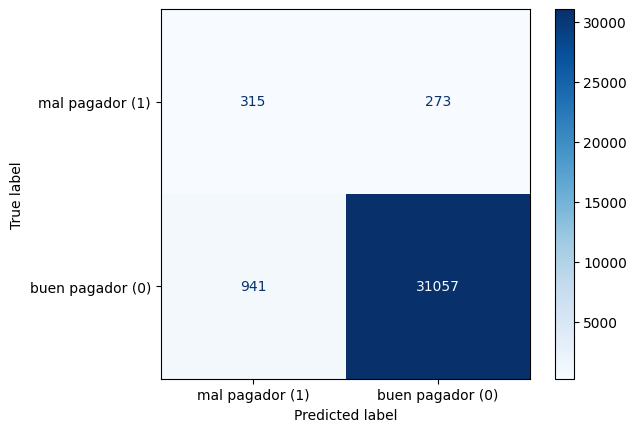

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


df_dummies['true_default'] = df['default_flag']

# matriz de confusión
cm = confusion_matrix(df_dummies['true_default'], df_dummies['predicted_default'], labels=[1, 0])

# Mostrar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['mal pagador (1)', 'buen pagador (0)'])
disp.plot(cmap="Blues")


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(df_dummies['true_default'], df_dummies['predicted_default'], target_names=['buen pagador (0)', 'mal pagador (1)']))


                  precision    recall  f1-score   support

buen pagador (0)       0.99      0.97      0.98     31998
 mal pagador (1)       0.25      0.54      0.34       588

        accuracy                           0.96     32586
       macro avg       0.62      0.75      0.66     32586
    weighted avg       0.98      0.96      0.97     32586



# Ajuste del modelo con regresión lineal

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report




In [18]:

# Separar las variables independientes (X) de la variable dependiente (y)
X = df_dummies.drop(columns=['default_flag', 'predicted_default'])
y = df_dummies['default_flag']



In [21]:
# Verificar tipos de datos en X
print(X.dtypes)

# Ver si hay columnas que siguen siendo de tipo object o string
non_numeric_columns = X.select_dtypes(include=['object']).columns
print(non_numeric_columns)

# Convertir a dummies si fuera necesario
if len(non_numeric_columns) > 0:
    X = pd.get_dummies(X, columns=non_numeric_columns)

user_id                                           Int64
number_dependents                                 Int64
age                                               Int64
last_month_salary                                 Int64
more_90_days_overdue                              Int64
using_lines_not_secured_personal_assets         float64
number_times_delayed_payment_loan_30_59_days      Int64
debt_ratio                                      float64
number_times_delayed_payment_loan_60_89_days      Int64
loan_count                                        Int64
real_estate                                       Int64
others                                            Int64
generation_q2                                      bool
generation_q3                                      bool
generation_q4                                      bool
loan_group_q2                                      bool
loan_group_q3                                      bool
loan_group_q4                                   

In [22]:
# Revisar si hay valores faltantes o nulos
print(X.isnull().sum())

# rellenar nulos con 0
X.fillna(0, inplace=True)


user_id                                         0
number_dependents                               0
age                                             0
last_month_salary                               0
more_90_days_overdue                            0
using_lines_not_secured_personal_assets         0
number_times_delayed_payment_loan_30_59_days    0
debt_ratio                                      0
number_times_delayed_payment_loan_60_89_days    0
loan_count                                      0
real_estate                                     0
others                                          0
generation_q2                                   0
generation_q3                                   0
generation_q4                                   0
loan_group_q2                                   0
loan_group_q3                                   0
loan_group_q4                                   0
m9do_group_other                                0
m9do_group_q1                                   0


In [23]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Revisar las dimensiones para asegurar que todo esté correcto
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(22810, 32) (9776, 32) (22810,) (9776,)


In [24]:
# Crear el modelo de regresión logística
model = LogisticRegression()

# Entrenar el modelo
model.fit(X_train, y_train)

# Predecir los valores del conjunto de prueba
y_pred = model.predict(X_test)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [25]:
# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de Confusión:")
print(conf_matrix)


# Reporte de clasificación
class_report = classification_report(y_test, y_pred, target_names=["buen pagador (0)", "mal pagador (1)"])
print("Reporte de Clasificación:")
print(class_report)


Matriz de Confusión:
[[9579   23]
 [  48  126]]
Reporte de Clasificación:
                  precision    recall  f1-score   support

buen pagador (0)       1.00      1.00      1.00      9602
 mal pagador (1)       0.85      0.72      0.78       174

        accuracy                           0.99      9776
       macro avg       0.92      0.86      0.89      9776
    weighted avg       0.99      0.99      0.99      9776



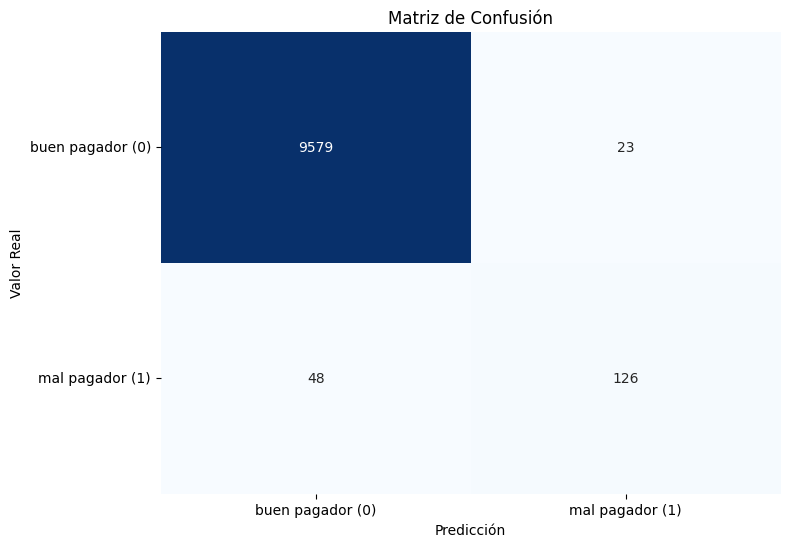

In [26]:
# Crear la figura y los ejes
plt.figure(figsize=(8, 6))

# Usar seaborn para crear un mapa de calor de la matriz de confusión
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)

# Añadir títulos y etiquetas
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Valor Real")

# Añadir etiquetas en los ejes X e Y
plt.xticks(ticks=[0.5, 1.5], labels=["buen pagador (0)", "mal pagador (1)"])
plt.yticks(ticks=[0.5, 1.5], labels=["buen pagador (0)", "mal pagador (1)"], rotation=0)

# Mostrar la gráfica
plt.show()


In [ ]:
from sklearn.linear_model import LogisticRegression

# Suponiendo que X y y son tus variables independientes y dependientes para todo el dataset
X_full = df_dummies.drop(columns=['true_default', 'category'])
y_full = df_dummies['true_default']

# Entrenar el modelo con todos los datos
model = LogisticRegression()
model.fit(X_full, y_full)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
# Predecir sobre todo el DataFrame
df['predicted_default'] = model.predict(X_full)

# Recategorizar los usuarios
df['recategorized_default'] = df['predicted_default'].apply(lambda x: 1 if x == 1 else 0)

# Verificar el DataFrame
print(df[['predicted_default', 'recategorized_default']])


       predicted_default  recategorized_default
0                    1.0                      1
1                    0.0                      0
2                    0.0                      0
3                    1.0                      1
4                    0.0                      0
...                  ...                    ...
32581                0.0                      0
32582                0.0                      0
32583                0.0                      0
32584                0.0                      0
32585                0.0                      0

[32586 rows x 2 columns]


In [ ]:
!pip install pandas-gbq


In [ ]:
from google.colab import auth
auth.authenticate_user()


In [ ]:
from google.cloud import bigquery
import pandas_gbq

# Configurar tu ID de proyecto en Google Cloud
project_id = "saltoproyecto3"

# Nombre de la tabla a crear en BigQuery
table_id = "saltoproyecto3.riesgorelativo.combined_view_2"

# Subir el DataFrame a BigQuery
pandas_gbq.to_gbq(df, table_id, project_id=project_id, if_exists='replace')


100%|██████████| 1/1 [00:00<00:00, 3066.01it/s]
